# Deep Q-Network (DQN)

The main difference with NFQ are:

- the use of a replay buffer, to break the correlation between consecutive samples 
- the use of a target network in order to simulate a IID problem and a more stable target
- the use of an exponentially decaying epsilon-greedy strategy, to explore more at the beginning and less at the end

In practice we don’t have two different networks. The target network is a previous instance of the same neural network that we freeze for a number of steps. The gradient update now has time to catch up to the target, which is much more stable when frozen. This adds stability to the updates. We use the same model architecture and "sometimes" update the weights of the target network to match the weights of the online network, which is the network we optimize on every step.

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class FCQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc

        # defining the input layer
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])

         # creating the hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)

        # connecting the output layer 
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, state):
        # take in the raw state and convert it into a tensor
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
        
        # pass it through the input layer
        x = self.activation_fc(self.input_layer(x))

        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        
        # finally, for the output layer
        x = self.output_layer(x)
        return x
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to('cpu')
        actions = torch.from_numpy(actions).long().to('cpu')
        new_states = torch.from_numpy(new_states).float().to('cpu')
        rewards = torch.from_numpy(rewards).float().to('cpu')
        is_terminals = torch.from_numpy(is_terminals).float().to('cpu')
        return states, actions, new_states, rewards, is_terminals

To balance the exploration-exploitation trade-off we use a exponentially decaying epsilon-greedy exploration strategy.

In [3]:
class EGreedyExpStrategy():
    
    def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
        
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_steps = decay_steps
        self.min_epsilon = min_epsilon
        self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
        self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
        self.t = 0
        self.exploratory_action_taken = None

    def _epsilon_update(self):
        
        # epsilon is decaying in an exponential curve
        self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
        self.t += 1
        return self.epsilon

    def select_action(self, model, state):
        
        self.exploratory_action_taken = False
        
        #with torch.no_grad():
        # pulling out the Q-values for state s
        q_values = model(state).detach()
        # make the values NumPy friendly 
        q_values = q_values.data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else:
            action = np.random.randint(len(q_values))

        self._epsilon_update()
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action
        return action

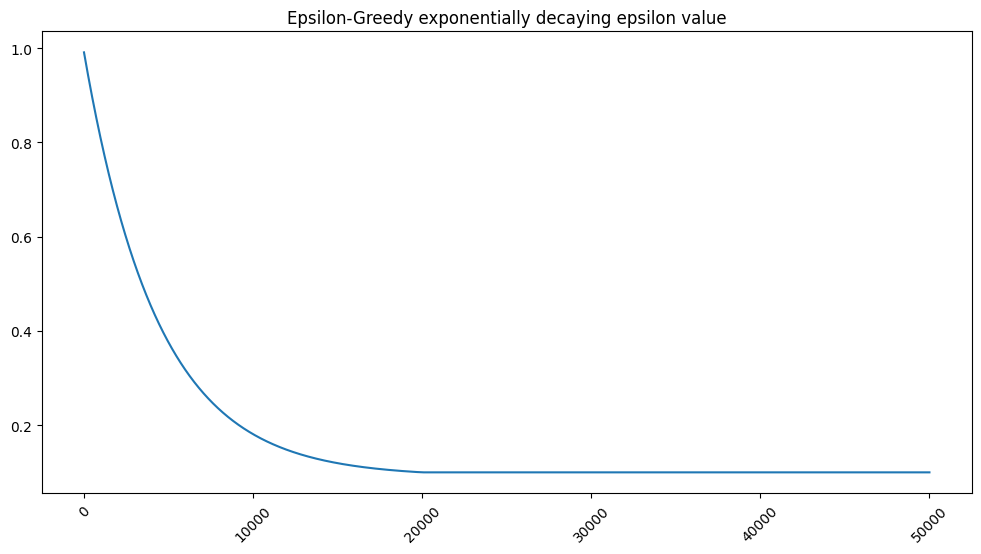

In [5]:
import matplotlib.pyplot as plt
import numpy as np

s = EGreedyExpStrategy()

plt.figure(figsize=(12,6))
plt.plot([s._epsilon_update() for _ in range(50000)])
plt.title('Epsilon-Greedy exponentially decaying epsilon value')
plt.xticks(rotation=45)

plt.show()

However, when evaluating the agent, we will use the action greedy with respect to the learned action-value function.

In [17]:
class GreedyStrategy():
    
    def select_action(self, model, state):
        with torch.no_grad():
            q_values = model(state).detach()
            q_values = q_values.data.numpy().squeeze()
            return np.argmax(q_values)

We create the Replay Memory, a data structure D to hold experience samples for several steps. The only difference is that we’re now obtaining the experiences we use for training by sampling uniformly at random the replay buffer D, instead of using the online experiences as before:

In [14]:
import numpy as np

class ReplayMemory():
    def __init__(self, max_size=10000, batch_size=64):
        
        # initialize five arrays to hold states, actions, reward, next states, and done flags
        self.states      = np.empty(shape=(max_size), dtype=np.ndarray)
        self.actions     = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rewards     = np.empty(shape=(max_size), dtype=np.ndarray)
        self.next_states = np.empty(shape=(max_size), dtype=np.ndarray)
        self.dones       = np.empty(shape=(max_size), dtype=np.ndarray)

        # variables to do storage and sampling
        self.max_size = max_size
        self.batch_size = batch_size
        self.idx = 0
        self.size = 0
    
    def store(self, sample):
        
        # store a new sample 
        state, action, reward, next_state, done = sample
        self.states[self.idx] = state
        self.actions[self.idx] = action
        self.rewards[self.idx] = reward
        self.next_states[self.idx] = next_state
        self.dones[self.idx] = done

        # idx points to the next index to modify, so we increase it, 
        # also make sure it loops back after reaching the maximum size 
        # (the end of the buffer)
        self.idx += 1
        self.idx = self.idx % self.max_size

        # size also increases with every new sample stored, 
        # but it doesn’t loop back to 0; it stops growing instead
        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size=None):
        
        # determining the batch size
        if batch_size == None:
            batch_size = self.batch_size

        # sample batch_size ids from 0 to size.    
        idxs = np.random.choice(self.size, batch_size, replace=False)
        
        # extract the experiences from the buffer using the sampled ids
        experiences = np.vstack(self.states[idxs]), \
                      np.vstack(self.actions[idxs]), \
                      np.vstack(self.rewards[idxs]), \
                      np.vstack(self.next_states[idxs]), \
                      np.vstack(self.dones[idxs])
                      
        return experiences

    # handy function to return the correct size of the memory
    def __len__(self):
        return self.size

Consider the optimize method of the new algorithm, notice that we use the target network to calculate the Q-values of the next state, but we use the online network to calculate the Q-values of the current state:

In [7]:
def optimize_model(self, experiences):

    # convert the experiences into separate arrays for each element
    states, actions, rewards, next_states, is_terminals = experiences

    # get the batch size
    batch_size = len(is_terminals)
        
    # get the values of the Q-function at next state (remember to detach
    # notice: we now query the "target" network to get the estimate of the next state 
    q_sp = self.target_model(next_states).detach()
        
    # get the max value of the next state
    max_a_q_sp = q_sp.max(1)[0].unsqueeze(1)
    
    # one important step, often overlooked, is to ensure 
    # terminal states are grounded to zero
    max_a_q_sp *= (1 - is_terminals)
        
    # calculate the target 
    target_q_sa = rewards + self.gamma * max_a_q_sp

    # finally, we get the current estimate of Q(s,a)    
    # notice: here we query the current "online" network
    q_sa = self.online_model(states).gather(1, actions)

    # create the errors
    td_errors = q_sa - target_q_sa
    
    # calculate the loss, and optimize the online network
    value_loss = td_errors.pow(2).mul(0.5).mean()

    self.optimizer.zero_grad()
    value_loss.backward()
    self.optimizer.step()

The following is the interaction step method on the new algorithm, notice that it uses the online network to explore the environment and the experience is collected in the replay buffer:

In [6]:
def interaction_step(self, state):
    
    # interact with environment using the exploration policy
    # notice how we use the online model for selecting actions
    action = self.train_strategy.select_action(self.online_model, state)

    # collect an experience tuple as usual    
    new_state, reward, is_terminal, is_truncated, info = self.env.step(action)

    # a failure is defined as follows
    is_failure = is_terminal and not is_truncated
    
    # collect the experience and store it in the replay buffer
    experience = (state, action, reward, new_state, float(is_failure))
    self.replay_memory.store(experience)

    # update episode stats
    self.episode_reward[-1] += reward
    self.episode_timestep[-1] += 1
    self.episode_exploration[-1] += int(self.train_strategy.exploratory_action_taken)
    
    return new_state, is_terminal

Finally, the following is how the target network gets updated with the online network:

In [8]:
def update_network(self):
    for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
        target.data.copy_(online.data)

As in NFQ, need a method to evaluate the learned policy using a greedy strategy:

In [9]:
def evaluate(self, n_episodes=1):

    # create a list of returns of each episode
    rs = []

    # loop over the episodes
    for _ in range(n_episodes):

        # reset the environment before starting the episode
        s, d = self.env.reset()[0], False

        # initialize the return
        rs.append(0)

        # interact with the environment until the episode is done 
        while(True):

            # interact with environment using the exploitation policy
            a = self.eval_strategy.select_action(self.online_model, s)

            # collect an experience tuple as usual
            s, r, d, t, _ = self.env.step(a)

             # add the reward to the return of the episode
            rs[-1] += r

            if d or t:
                break
            
    return np.mean(rs), np.std(rs)

We can now implement the full DQN algorithm, the main difference with NFQ are that we use an exponentially decaying epsilon-greedy strategy to improve policies, we use a replay buffer and a target network. So the algorithm has three main steps:

1. collect experience and insert it into the replay memory
2. randomly sample a mini-batch from the buffer, and calculate the off-policy TD targets for the whole batch
3. fit the action-value function Q(s,a; θ) using MSE and RMSprop

In [10]:
import random 
import torch
import torch.optim as optim

class DQN():
    def __init__(self, env, online_model, target_model, optimizer, 
                 train_strategy, eval_strategy, replay_memory,
                 seed, n_warmup_batches, target_update_steps):
        
        # set the seed
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        # store the objects
        self.env = env
        self.replay_memory = replay_memory
        self.online_model = online_model
        self.target_model = target_model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.n_warmup_batches = n_warmup_batches
        self.target_update_steps = target_update_steps

In [11]:
DQN.optimize_model = optimize_model
DQN.interaction_step = interaction_step
DQN.update_network = update_network
DQN.evaluate = evaluate

We need to write the new training loop, the difference with NFQ are that we need to sample a mini-batch from the replay memory,we never need to use the same mini-batch for multiple epochs and sometimes we have to synchronize the target network with the online network:

In [12]:
from itertools import count
import time

def train(self, gamma, max_minutes, max_episodes, goal_reward):
        
        # timing variables
        training_start = time.time()

        self.gamma = gamma
        
        # stats trackers 
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        # we synchronize the online and target models at the beginning of training
        self.update_network()
                    
        result = np.empty((max_episodes, 4))
        result[:] = np.nan

        training_time = 0
        
        # train until we either reach the max minutes, the max episodes or the goal mean reward
        for episode in range(1, max_episodes + 1):

            # get the start time of the episode
            episode_start = time.time()
            
            # reset the episode trackers
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            # reset the environment before starting the episode
            state, is_terminal = self.env.reset()[0], False

            # interact with the environment until the episode is done
            for step in count():

                # interact with environment using the exploration policy
                # and collect the experience in the replay memory
                state, is_terminal = self.interaction_step(state)
                
                # if the replay memory has enough samples, we can create 
                # the mini-batch and optimize the model 
                min_samples = self.replay_memory.batch_size * self.n_warmup_batches
                if len(self.replay_memory) > min_samples:

                    # load the experiences as tensors for training
                    # from the replay memory
                    experiences = self.replay_memory.sample()
                    experiences = self.online_model.load(experiences)

                    # optimize the model
                    self.optimize_model(experiences)
                
                # synchronize the target model with the online model
                if np.sum(self.episode_timestep) % self.target_update_steps == 0:
                    self.update_network()
                
                if is_terminal:
                    break
            
            # timing stuff
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed

            # episode steps count
            total_step = int(np.sum(self.episode_timestep))

            # evaluate the learned policy after the episode
            evaluation_score, _ = self.evaluate()
            self.evaluation_scores.append(evaluation_score)
            
            # average stats over some recent episodes
            mean_100_train_reward = np.mean(self.episode_reward[-100:])
            std_100_train_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])

            # report results
            result[episode-1] = total_step, mean_100_train_reward, mean_100_eval_score, training_time
            
            # check max episodes, max minutes and goal achievement criteria
            total_elapsed = time.time() - training_start
            reached_max_minutes = total_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_reward
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
            
            # informative print logging  
            debug_message = 'episode {:04}, steps {:06}, avg eval score {:05.1f} (+/- {:05.1f})'
            debug_message = debug_message.format(episode, total_step, mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            
            # conclude training if we have met any of the stopping conditions
            if training_is_over:
                print(debug_message)
                if reached_max_minutes: print(u'--> reached_max_minutes ')
                if reached_max_episodes: print(u'--> reached_max_episodes ')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward ')
                break
                
        # evaluate the final policy
        final_eval_score, final_eval_std = self.evaluate(n_episodes=100)
        
        return result, final_eval_score, final_eval_std, training_time
    
DQN.train = train


We can show the performance of DQN on the cart-pole environment in order to show that it is more powerful than NFQ. We can also show that the target network and the replay buffer are important for the stability of the algorithm.

In [15]:
import gymnasium
cartpole = gymnasium.make('CartPole-v1', render_mode="rgb_array")

In [18]:
gamma = 1.00

max_minutes = 20
max_episodes = 10000
goal_reward = 350

dqn_results = []
best_dqn_agent = None 
best_dqn_eval_score = float('-inf')

target_update_steps = 10
n_warmup_batches = 5

nS, nA = cartpole.observation_space.shape[0], cartpole.action_space.n

for seed in (12, 34, 56, 78, 90):
    
    print('Training started...')
    
    online_model = FCQ(nS, nA, hidden_dims=(512,128))
    target_model = FCQ(nS, nA, hidden_dims=(512,128))
    optimizer = optim.RMSprop(online_model.parameters(), lr=0.0005)
    replay_memory = ReplayMemory(max_size=50000, batch_size=64)
    train_strategy = EGreedyExpStrategy(init_epsilon=1.0, min_epsilon=0.3, decay_steps=20000)
    eval_strategy = GreedyStrategy()
    
    agent = DQN(cartpole, online_model, target_model, optimizer, 
                train_strategy, eval_strategy, replay_memory, seed, 
                n_warmup_batches, target_update_steps)
    result, score, score_std, training_time = agent.train(gamma, max_minutes, max_episodes, goal_reward)

    dqn_results.append(result)
    if score > best_dqn_eval_score:
        best_dqn_eval_score = score
        best_dqn_agent = agent

    print('...training complete.')
    print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time\n'.format(score, score_std, training_time))
    
dqn_results = np.array(dqn_results)

Training started...
episode 0199, steps 042157, avg eval score 350.4 (+/- 115.0)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 50.38s training time

Training started...
episode 0771, steps 156046, avg eval score 351.9 (+/- 204.9)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 428.98±45.66 in 225.55s training time

Training started...
episode 0226, steps 063013, avg eval score 352.1 (+/- 125.9)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 84.22s training time

Training started...
episode 1050, steps 243568, avg eval score 354.1 (+/- 213.4)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 495.72±13.05 in 356.15s training time

Training started...
episode 0174, steps 029191, avg eval score 350.9 (+/- 115.9)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 32.73s training time



In [19]:
dqn_max_steps, dqn_max_train_reward, dqn_max_eval_score, dqn_max_time = np.max(dqn_results, axis=0).T
dqn_min_steps, dqn_min_train_reward, dqn_min_eval_score, dqn_min_time = np.min(dqn_results, axis=0).T
dqn_mean_steps, dqn_mean_train_reward, dqn_mean_eval_score, dqn_mean_time = np.mean(dqn_results, axis=0).T
dqn_episodes = np.arange(len(dqn_mean_steps))

We can save the result to future comparison:

In [20]:
np.savez('dqn_results',
         dqn_max_steps = dqn_max_steps, dqn_max_train_reward = dqn_max_train_reward, dqn_max_eval_score = dqn_max_eval_score, dqn_max_time = dqn_max_time,
         dqn_min_steps = dqn_min_steps, dqn_min_train_reward = dqn_min_train_reward, dqn_min_eval_score = dqn_min_eval_score, dqn_min_time = dqn_min_time,  
         dqn_mean_steps = dqn_mean_steps, dqn_mean_train_reward = dqn_mean_train_reward, dqn_mean_eval_score = dqn_mean_eval_score, dqn_mean_time = dqn_mean_time)


We can load the result of NFQ in order to compare the performances of the two algorithms:

In [21]:
nfq_results = np.load('nfq_results.npz')
nfq_max_steps = nfq_results['nfq_max_steps']
nfq_max_train_reward = nfq_results['nfq_max_train_reward']
nfq_max_eval_score = nfq_results['nfq_max_eval_score']
nfq_max_time = nfq_results['nfq_max_time']
nfq_min_steps = nfq_results['nfq_min_steps']
nfq_min_train_reward = nfq_results['nfq_min_train_reward']
nfq_min_eval_score = nfq_results['nfq_min_eval_score']
nfq_min_time = nfq_results['nfq_min_time']
nfq_mean_steps = nfq_results['nfq_mean_steps']
nfq_mean_train_reward = nfq_results['nfq_mean_train_reward']
nfq_mean_eval_score = nfq_results['nfq_mean_eval_score']
nfq_mean_time = nfq_results['nfq_mean_time']
nfq_episodes = np.arange(len(nfq_mean_steps))

We can plot the training reward:

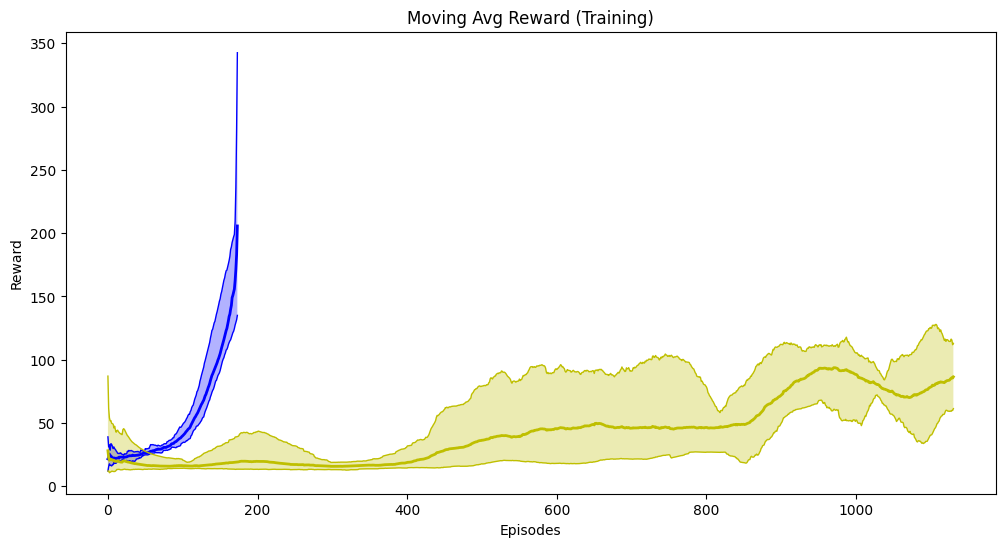

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(dqn_max_train_reward, 'b', linewidth=1)
plt.plot(dqn_min_train_reward, 'b', linewidth=1)
plt.plot(dqn_mean_train_reward, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_train_reward, dqn_max_train_reward, facecolor='b', alpha=0.3)

plt.plot(nfq_max_train_reward, 'y', linewidth=1)
plt.plot(nfq_min_train_reward, 'y', linewidth=1)
plt.plot(nfq_mean_train_reward, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_train_reward, nfq_max_train_reward, facecolor='y', alpha=0.3)

plt.title('Moving Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

The most obvious conclusion we can draw is that DQN is more sample efficient than NFQ. But, if you pay attention to the curves, you notice how NFQ is also noisier than DQN.

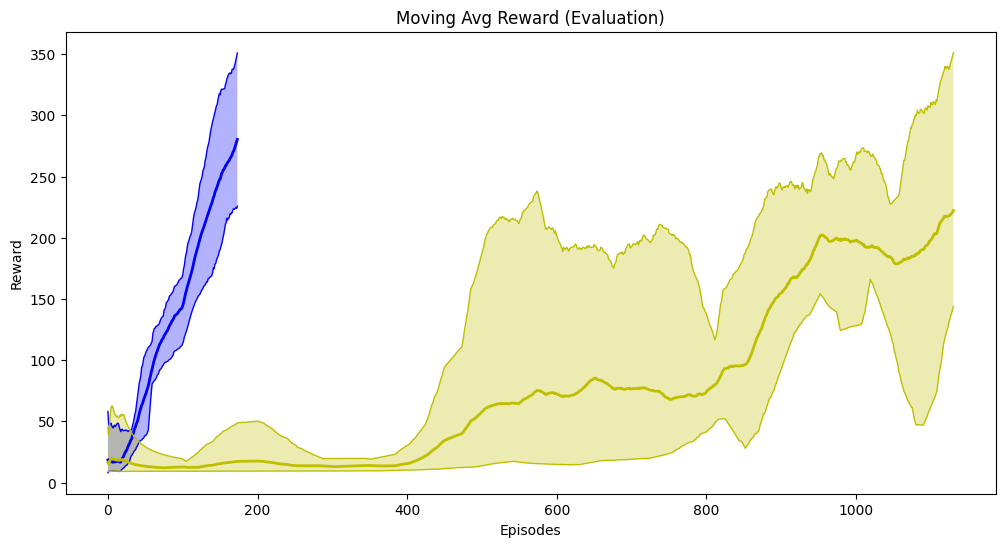

In [26]:
plt.figure(figsize=(12,6))

plt.plot(dqn_max_eval_score, 'b', linewidth=1)
plt.plot(dqn_min_eval_score, 'b', linewidth=1)
plt.plot(dqn_mean_eval_score, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_eval_score, dqn_max_eval_score, facecolor='b', alpha=0.3)

plt.plot(nfq_max_eval_score, 'y', linewidth=1)
plt.plot(nfq_min_eval_score, 'y', linewidth=1)
plt.plot(nfq_mean_eval_score, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_eval_score, nfq_max_eval_score, facecolor='y', alpha=0.3)

plt.title('Moving Avg Reward (Evaluation)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

Notice that they both pass the cart-pole environment, but DQN takes approximately 200 episodes while NFQ takes almost 1,500 episodes. That’s a tenfold reduction in samples.

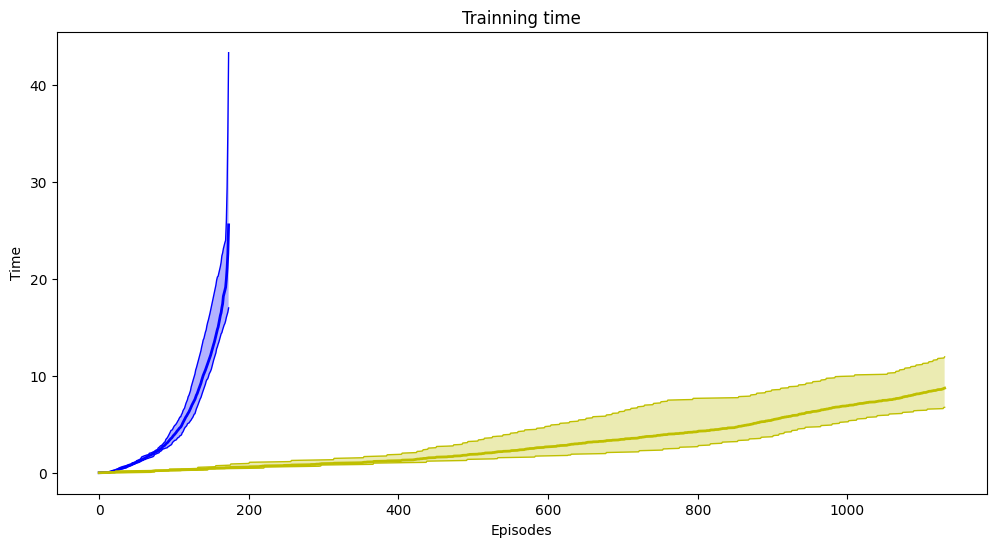

In [27]:
plt.figure(figsize=(12,6))

plt.plot(dqn_max_time, 'b', linewidth=1)
plt.plot(dqn_min_time, 'b', linewidth=1)
plt.plot(dqn_mean_time, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_time, dqn_max_time, facecolor='b', alpha=0.3)

plt.plot(nfq_max_time, 'y', linewidth=1)
plt.plot(nfq_min_time, 'y', linewidth=1)
plt.plot(nfq_mean_time, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_time, nfq_max_time, facecolor='y', alpha=0.3)

plt.title('Trainning time')
plt.ylabel('Time')
plt.xlabel('Episodes')
plt.show()

However, DQN takes more training time than NFQ to pass the environment.